
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Other approach:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

Issue comes when there is some separator: How to implement it? Idea: Use a random token to represent it.

## Weight update:
 - Make the updatable weights constant and then update it dynamically
 - train it once and them update it dynamically in the forward pass
 - cache weight matrices and train them individually -> this does not train properly (super slow convergence)


In [1]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo

# eventually include tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# ML resources:
import torch
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#others:
import pandas as pd
import numpy as np


punctuation = [".",",","?", "!",";",":","-","_","(",")","[","]","{","}"]


## DataLoader not implemented yet:

In [3]:
## annoying to adapt a bit

class DailyDialogDataset(Dataset):
  def __init__(self, text, emot,text_class,emot_class):
  # Dataset object for Daily Dialog dataset
    self.text = text               ## text with embeddings
    self.emot = emot               ## emotion with embeddings
    self.text_class = text_class   ## text for CrossEntropy
    self.emot_class = emot_class   ## emotions for CrossEntropy

  def __len__(self):
    return len(self.text)

  def __getitem__(self, idx):
    item = {
        'text': self.text[idx],
        'emot': self.emot[idx],
        'text_class': self.text_class[idx],
        'emot_class': self.emot_class[idx]
    }
    return item



Here we will extract the data:

In [4]:
emotions_emb = {}

data = load_dataset('daily_dialog')
X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']

bagofwords = []
emotions = []

for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

While dataloader is not implemented, we have this:

In [5]:
def Preprocess_Data(X_,Y_): ## We do some simple prepocessing
  bagofwords = []
  emotions = []
  X = X_
  Y = Y_
  for i in range(len(X)):
    l1 = []
    l2 = []
    for j in range(len(X[i])):
      to_append = X[i][j].lower().split()
      l1.extend(to_append)
      l2.extend([Y[i][j]]*len(to_append))
      bagofwords.append(to_append)
    X[i] = l1
    Y[i] = l2

  for i in range(len(X)): ## remove puncuation
    to_remove = []
    for j in range(len(X[i])):
      if X[i][j] in punctuation:
        to_remove.append(j)
    for j in to_remove[::-1]:
      X[i].pop(j)
      Y[i].pop(j)
  for i in Y:
    for j in i:
      emotions.append(j)
  emotions = list(set(emotions))

  for lx,ly in zip(X,Y):
    assert(len(lx) == len(ly))
  return X_, Y_, bagofwords, emotions

X_train,Y_train, bagofwords1, emotions = Preprocess_Data(X_train,Y_train)
X_test,Y_test, bagofwords2, _ = Preprocess_Data(X_test,Y_test)
X_val,Y_val, bagofwords3, _ = Preprocess_Data(X_val,Y_val)



In [6]:
for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

print("train size: ",len(X_train))
print("test size: ",len(X_test))
print("validation size: ",len(X_val))
print("emotions: ",emotions)


train size:  11118
test size:  1000
validation size:  1000
emotions:  [0, 1, 2, 3, 4, 5, 6]


Now we train w2v:

In [7]:
word_dim = 300
w2v = Word2Vec(sentences=bagofwords1, vector_size=word_dim, min_count=1)

print("vocabulary size: ",len(w2v.wv))

vocabulary size:  22075


In [8]:
if len(emotions_emb) > 0:
    pass
else:
  emotions_emb = {}

## this continues the preprocess: We get the encoding for each word in the dataset:
def encode_text(X):
  train_X = []
  words_list = []
  train_X_class = {}
  for dialog in X:
    for word in dialog:
      if word not in words_list:
        words_list.append(word)
      try:
        tens = torch.from_numpy(w2v.wv[word])
        tens = tens.type(torch.float32)
      except:
        tens = torch.rand(word_dim,dtype=torch.float32)
      train_X.append(tens)
  stoi = {word:i for i,word in enumerate(words_list)}
  itos = {i:word for i,word in enumerate(words_list)}
  X_utt = []
  for i,word in itos.items():
    tens = torch.zeros(len(words_list))
    tens[i] = 1
    train_X_class[word] = tens
  for dialog in X:
    for word in dialog:
      X_utt.append(stoi[word])
  return train_X, stoi, itos, train_X_class,X_utt

## We do something similar to the emotions (but we initialized them randomly)
def encode_emotions(Y,emotions_emb,plot_=False):
  train_Y = []
  Y_emo = []
  plot_data = {i:0 for i in emotions}
  if len(emotions_emb) == 0:
    for emotion in emotions:
      emotions_emb[emotion] = torch.rand(word_dim,dtype=torch.float32) ## sabe the embeddings of each word
  for dialog in Y:
    for em in dialog:
      train_Y.append(emotions_emb[em])
      Y_emo.append(em)
    if plot_:
      plot_data[em] += 1
  return train_Y, Y_emo

X_train1, stoi_train1, itos_train1, train_X_class,X_train_utt = encode_text(X_train)
Y_train1, Y_train_emo = encode_emotions(Y_train,emotions_emb)

X_test1, _, _, test_X_class,  X_test_utt  = encode_text(X_test)
Y_test1, Y_test_emo = encode_emotions(Y_test,emotions_emb)

X_val1, _, _, val_X_class, X_val_utt = encode_text(X_val)
Y_val1, Y_val_emo= encode_emotions(Y_val,emotions_emb)



<ipython-input-8-c2a7ea7bb7bb>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tens = torch.from_numpy(w2v.wv[word])


In [9]:
for i, vec in enumerate(train_X_class.values()):
  assert(i == torch.argmax(vec))

batch_size = 800
train_data = DailyDialogDataset(X_train1[:-1],Y_train1[:-1],X_train_utt[1:],Y_train_emo[1:])
test_data = DailyDialogDataset(X_test1[:-1],Y_test1[:-1],X_test_utt[1:],Y_test_emo[1:])
val_data = DailyDialogDataset(X_val1[:-1],Y_val1[:-1],X_val_utt[1:],Y_val_emo[1:])

train_loader = DataLoader(train_data, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True)


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (Not implemented yet)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [10]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, n_emb_utt, n_emb_emo, emotions_size, vocab_size):
    super(SimpleModel,self).__init__()
    ## Decide size later!
    self.decoder = nn.Linear(n_emb_utt,vocab_size)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(n_emb_utt,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)
    self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(n_emb_utt,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final = nn.Linear(380, n_emb_utt)
    self.Linear_emo_final = nn.Linear(380, emotions_size)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text_emb, emo_emb):

    x = self.Linear_utt1(text_emb)
    x = self.Linear_utt2(x)
    x = self.Linear_utt3(x)

    y = self.Linear_emo1(emo_emb)
    y = self.Linear_emo2(y)
    y = self.Linear_emo3(y)

    z = torch.cat((x,y),-1) ## very simple
    z = self.Linear_fus(z)

    w = torch.cat((z,x),-1)

    pred_token = self.Linear_utt_final(w)
    pred_token = self.decoder(pred_token)
    pred_token = self.softmax(pred_token)

    v = torch.cat((z,y),-1)
    v = self.Linear_emo_final(v)

    pred_emotion = self.softmax(v)
    return pred_token, pred_emotion



In [70]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## normal train function
def train(model, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss1 = 0
  loss2 = 0
  loss = 0
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
      batch = {'text': batch['text'].to(device), 'emot': batch['emot'].to(device), 'text_class': batch['text_class'].to(device), 'emot_class': batch['emot_class'].to(device)}
      optimizer.zero_grad()
      pt, pe  = model.forward(batch['text'],batch['emot'])
      loss1 = loss_fn(pe, batch['emot_class'])
      loss2 = loss_fn(pt, batch['text_class'])
      loss = loss1 + loss2
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    loss_to_append = sum(losses)/len(losses)
    loss_to_plot.append(loss_to_append)
    print(f"loss: ",loss_to_append)
  return loss_to_plot


In [71]:
device = activate_gpu()
fn = nn.CrossEntropyLoss()
model = SimpleModel(word_dim,word_dim,len(emotions),len(train_X_class))
print(device)

DEVICE =  Tesla T4
cuda


Epoch 1/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.940275966787605
Epoch 2/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9422408693985973
Epoch 3/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9422070345432638
Epoch 4/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9433306957796799
Epoch 5/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9439430320672662
Epoch 6/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9447306879609227
Epoch 7/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9447204503509925


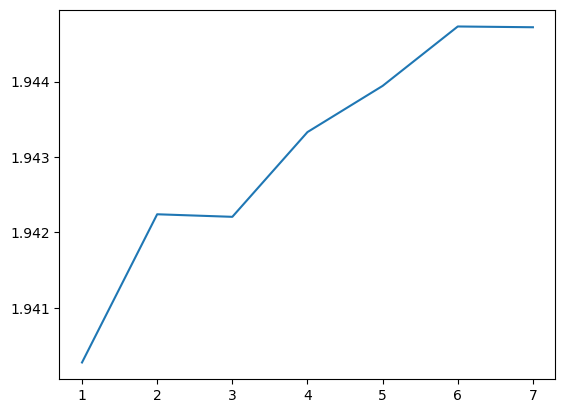

In [75]:
epochs = 7

losses = train(model,epochs,device)
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [76]:
def compute_test_loss(model,loss_fn,data_loader,device):
  model.eval()
  losses = []
  accs = []
  preds = []
  prec = 0
  trues = []
  pred_words = []
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'text' : batch['text'].to(device),'emot': batch['emot'].to(device),'text_class': batch['text_class'].to(device),'emot_class': batch['emot_class'].to(device)}
    pt, pe  = model.forward(batch['text'],batch['emot'])
    loss = loss_fn(pe,batch['emot_class'])
    index_pred = torch.argmax(pe,1)
    word_p = torch.argmax(pt,1)
    correct = (batch['emot_class'].flatten() == index_pred.flatten()).float().sum()
    acc = correct/len(index_pred.flatten())
    accs.append(acc.item())
    losses.append(loss.item())
    trues.extend(batch['emot_class'].flatten().tolist())
    preds.extend(index_pred.tolist())
    pred_words.extend(word_p.tolist())
    for i in batch['text_class']:
      i.item()
  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds, word_p
trues, preds, pred_words = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader,device)
names = [f'{i}' for i in range(1,8)]



  0%|          | 0/115 [00:00<?, ?it/s]

average loss:  1.9445405493611876
average acc:  0.6574382173707304


In [77]:
#for i,w,q in zip(trues[:50],preds[:50],pred_words[:50]):
#  print(i,w,itos_train1[q.item()])
#
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
confusion_matrix(trues,preds)

              precision    recall  f1-score   support

           1       0.96      0.72      0.82     82011
           2       0.00      0.00      0.00      1083
           3       0.00      0.00      0.00        41
           4       0.16      0.17      0.16       126
           5       0.01      0.02      0.01      6231
           6       0.93      0.93      0.93      1085
           7       0.81      0.27      0.40      1033

    accuracy                           0.66     91610
   macro avg       0.41      0.30      0.33     91610
weighted avg       0.88      0.66      0.75     91610



array([[59060,  9073,   402,     7, 13373,    68,    28],
       [ 1064,     1,     5,     1,    10,     2,     0],
       [   28,     0,     0,     0,     1,     0,    12],
       [    7,    54,     0,    21,    24,     0,    20],
       [  509,    20,  5588,     2,   106,     4,     2],
       [   49,     4,     5,     1,    16,  1008,     2],
       [  621,     4,    11,   100,    19,     3,   275]])

In [ ]:
def eval_sentence(model, sentence, encoded_sentence, emotions, device):
  model.eval()
  for i in range(len(sentence) - 1):
    pe, _ = model.forward(encoded_sentence[i].to(device),emotions[i].to(device))
    t = torch.max(pe,1)
    print(f"word:{sentence[i+1]}; predicted_emotion: {t} ; target_emotion: {emotions[i+1]}")

# eval_sentence(model,sentence,encod,emot,device)